In [1]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
# Импортируем предварительно обученную модель без верхнего слоя (без головы)
trained_model = VGG16(
    include_top=False, # Указываем, что необходимо исключить верхний слой с классификационной информацией
    weights='imagenet', # Загружаем веса, предварительно обученные на наборе данных ImageNet
    input_shape=(224,224,3)) # Устанавливаем форму входных данных модели (размер изображения 224x224x3)

In [3]:
# Замораживаем слои, чтобы предотвратить повторное обучение, кроме последних 4 слоев
for layer in trained_model.layers[:-4]:
    layer.trainable = False  # Устанавливаем свойство trainable в False для всех слоев, кроме последних 4

In [4]:
# Проверяем, доступны ли последние 4 слоя для обучения
for layer in trained_model.layers:
    print(layer, layer.trainable)  # Выводим информацию о каждом слое и его свойстве trainable

<keras.engine.input_layer.InputLayer object at 0x000001CE8409F198> False
<keras.layers.convolutional.Conv2D object at 0x000001CE8409F4A8> False
<keras.layers.convolutional.Conv2D object at 0x000001CE8404DA58> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CE83C7EF60> False
<keras.layers.convolutional.Conv2D object at 0x000001CE83C8A550> False
<keras.layers.convolutional.Conv2D object at 0x000001CE840C4B38> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CE840FBBE0> False
<keras.layers.convolutional.Conv2D object at 0x000001CE8410C9E8> False
<keras.layers.convolutional.Conv2D object at 0x000001CE8411FEF0> False
<keras.layers.convolutional.Conv2D object at 0x000001CE84131FD0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001CE84159CF8> False
<keras.layers.convolutional.Conv2D object at 0x000001CE8416AB00> False
<keras.layers.convolutional.Conv2D object at 0x000001CE8417BD30> False
<keras.layers.convolutional.Conv2D object at 0x000001CE8418C5C0> False
<ker

In [5]:
# На основе предварительно обученной модели добавляем новые слои и выходной слой для обучения на новом наборе данных
model = models.Sequential()  # Создаем последовательную модель
model.add(trained_model)  # Добавляем предварительно обученную модель в качестве первого слоя
model.add(layers.Flatten())  # Добавляем слой Flatten для преобразования выходных данных предыдущего слоя в одномерный вектор
model.add(layers.Dense(256, activation='relu'))  # Добавляем полносвязный слой с 256 нейронами и функцией активации ReLU
model.add(layers.Dropout(0.5))  # Добавляем слой Dropout для регуляризации и предотвращения переобучения
model.add(layers.Dense(5, activation='softmax'))  # Добавляем выходной слой с 5 нейронами и функцией активации Softmax

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 21,138,757
Trainable params: 13,503,493
Non-trainable params: 7,635,264
_________________________________________________________________


In [7]:
# Предобработка изображений
# Учитывая небольшое количество изображений в обучающем наборе данных, используем аугментацию данных для максимального использования доступных изображений при обучении
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Масштабируем значения пикселей изображений к диапазону [0, 1]
    rotation_range=20,  # Устанавливаем диапазон вращения изображений в градусах
    width_shift_range=0.2,  # Устанавливаем диапазон сдвига изображений по ширине
    height_shift_range=0.2,  # Устанавливаем диапазон сдвига изображений по высоте
    horizontal_flip=True,  # Выполняем горизонтальное отражение изображений
    fill_mode='nearest')  # Заполнение новых пикселей при аффинных преобразованиях изображения

validation_datagen = ImageDataGenerator(rescale=1./255)  # Масштабируем значения пикселей изображений в валидационном наборе данных к диапазону [0, 1]

In [8]:
# Определяем размер пакетов для обучения и пути к обучающему и валидационному наборам данных
training_batchsize = 50  # Размер пакета для обучающего набора данных
validation_batchsize = 10  # Размер пакета для валидационного набора данных
training_path = "Data/ImageNet_images/training"
validation_path = "Data/ImageNet_images/validation"
image_size = (224,224)  # Размер изображений (высота, ширина), который ожидает модель

In [9]:
# Получаем данные для обучения и валидации
train_generator = train_datagen.flow_from_directory(
    training_path,  # Путь к обучающему набору данных
    target_size=image_size,  # Размер изображений (высота, ширина), который ожидает модель
    batch_size=training_batchsize,  # Размер пакета для обучающего набора данных
    class_mode='categorical')  # Тип задачи классификации - категориальная

validation_generator = validation_datagen.flow_from_directory(
    validation_path,  # Путь к валидационному набору данных
    target_size=image_size,  # Размер изображений (высота, ширина), который ожидает модель
    batch_size=validation_batchsize,  # Размер пакета для валидационного набора данных
    class_mode='categorical',  # Тип задачи классификации - категориальная
    shuffle=False)  # Не перемешиваем данные, чтобы сохранить соответствие между изображениями и метками

Found 5765 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [10]:
# Компилируем модель
model.compile(loss='categorical_crossentropy',  # Используем категориальную кросс-энтропию в качестве функции потерь
            optimizer=optimizers.RMSprop(lr=1e-5),  # Используем оптимизатор RMSprop с коэффициентом скорости обучения 1e-5
            metrics=['acc'])  # Оцениваем модель по точности классификации

# Обучаем модель
history = model.fit_generator(
    train_generator,  # Используем обучающий генератор для получения данных
    steps_per_epoch=train_generator.samples/train_generator.batch_size,  # Устанавливаем количество шагов на одну эпоху
    epochs=30,  # Количество эпох обучения
    validation_data=validation_generator,  # Используем валидационный генератор для оценки модели в конце каждой эпохи
    validation_steps=validation_generator.samples/validation_generator.batch_size,  # Устанавливаем количество шагов валидации на одну эпоху
    verbose=2)  # Выводим подробную информацию о процессе обучения

# Сохраняем модель
model.save('model_VGG16.h5')

Epoch 1/30
 - 3771s - loss: 1.0196 - acc: 0.6008 - val_loss: 0.4730 - val_acc: 0.8140
Epoch 2/30
 - 3714s - loss: 0.5156 - acc: 0.8116 - val_loss: 0.3179 - val_acc: 0.8740
Epoch 3/30
 - 3701s - loss: 0.3933 - acc: 0.8637 - val_loss: 0.2663 - val_acc: 0.8860
Epoch 4/30
 - 3698s - loss: 0.3233 - acc: 0.8898 - val_loss: 0.2568 - val_acc: 0.8980
Epoch 5/30
 - 3707s - loss: 0.2867 - acc: 0.9002 - val_loss: 0.2239 - val_acc: 0.9140
Epoch 6/30
 - 3700s - loss: 0.2597 - acc: 0.9071 - val_loss: 0.2022 - val_acc: 0.9260
Epoch 7/30
 - 3708s - loss: 0.2285 - acc: 0.9234 - val_loss: 0.1992 - val_acc: 0.9260
Epoch 8/30
 - 3708s - loss: 0.2144 - acc: 0.9203 - val_loss: 0.1953 - val_acc: 0.9280
Epoch 9/30
 - 3702s - loss: 0.1956 - acc: 0.9287 - val_loss: 0.2254 - val_acc: 0.9240
Epoch 10/30
 - 3684s - loss: 0.1833 - acc: 0.9325 - val_loss: 0.1894 - val_acc: 0.9340
Epoch 11/30
 - 3681s - loss: 0.1761 - acc: 0.9382 - val_loss: 0.1746 - val_acc: 0.9380
Epoch 12/30
 - 3743s - loss: 0.1557 - acc: 0.9448 - 

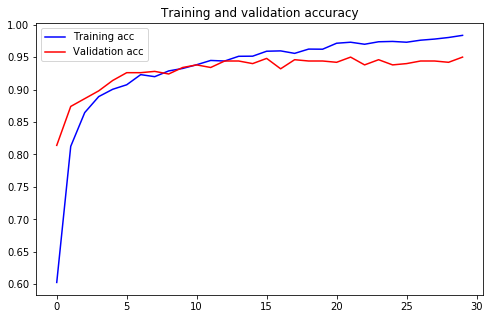

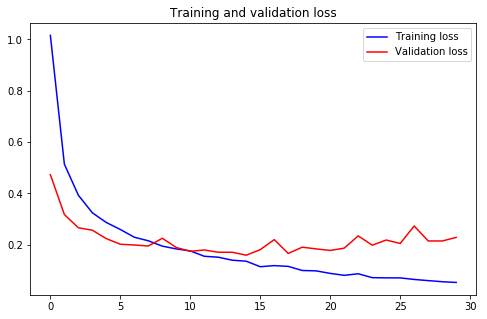

In [11]:
# Графики точности и функции потерь на обучающем и валидационном наборах данных
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'b', label='Training acc')  # График точности на обучающем наборе данных
plt.plot(epochs, val_acc, 'r', label='Validation acc')  # График точности на валидационном наборе данных
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(8,5)) 
plt.plot(epochs, loss, 'b', label='Training loss')  # График функции потерь на обучающем наборе данных
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # График функции потерь на валидационном наборе данных
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
# Получаем предсказанный класс цветка с помощью новой модели
predicted_class = my_model.predict_generator(validation_generator)

# Для каждого изображения предсказание представляет собой список вероятностей для каждого класса. Определяем максимальную вероятность и возвращаем ее индекс, который представляет метку класса в модели
predicted_class = np.argmax(predicted_class, axis=1)

In [13]:
# Получаем фактический класс цветка из валидационных данных
actual_class = validation_generator.classes

# Создаем матрицу ошибок
cnf_matrix = confusion_matrix(actual_class, predicted_class)

In [15]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Устанавливаем порог для изменения цвета шрифта таким образом, чтобы темный фон имел светлый цвет текста
    threshold = cm.max() / 2.
    # Используем цикл для построения текста в матрице ошибок
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # текст рисуется слева направо, поэтому используем (j, i), а не (i, j)
            plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")
    plt.ylabel('Actual Flower Class')
    plt.xlabel('Predicted Flower Class')

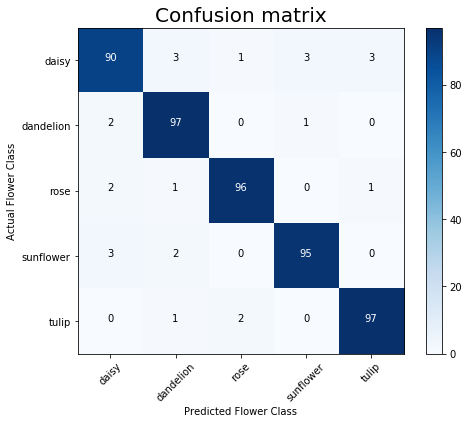

In [16]:
# Строим матрицу ошибок с определенными метками классов
plot_confusion_matrix(cnf_matrix, classes=["daisy", "dandelion", "rose", "sunflower", "tulip"])
plt.show()